<a href="https://colab.research.google.com/github/mloyorev/Theory/blob/main/8_InvestmentAdjustmentCostsNumba.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
!pip install quantecon

In [24]:
from collections import namedtuple
import numpy as np
import quantecon as qe
from numba import njit, prange, int32
import matplotlib.pyplot as plt

Once **again**, we use the functions:


*   `argmax`
*   `succesive approximation`



In [25]:
@njit
def argmax(list_object):
    max_val = -np.inf
    argmax_index = None
    for i, x in enumerate(list_object):
        if x > max_val:
            max_val = x
            argmax_index = i
    return argmax_index

In [27]:
def successive_approx(T,
                      x_0,
                      tolerance=1e-6,
                      max_iter=10_000,
                      print_step=25,
                      verbose=False):
    x = x_0
    error = tolerance + 1
    k = 1
    while error > tolerance and k <= max_iter:
        x_new = T(x)
        error = np.max(np.abs(x_new - x))
        if verbose and k % print_step == 0:
            print(f"Completed iteration {k} with error {error}.")
        x = x_new
        k += 1
    if error > tolerance:
        print(f"Warning: Iteration hit upper bound {max_iter}.")
    elif verbose:
        print(f"Terminated successfully in {k} iterations.")
    return x

# **Investment with Adjustment Costs**

We begin by assuming the case of a **monopolist facing an inverse demanda function** given by

$$P_{t}=a_{0}-a_{1}Y_{t}+Z_{t}$$

where


*   $P_{t}$ is the price,
*   $Y_{t}$ is the output,
*   $a_{0}$ and $a_{1}$ are demand parameters, and
*   $Z_{t}$ is the demand shock.

The profits of the monopolist are represented by

$$\pi(Y_{t},Y_{t+1}, Z_{t})=(a_{0}-a_{1}Y_{t}+Z_{t})Y_{t}-\gamma (Y_{t+1}-Y_{t})^{2}$$

where the **investment adjustment cost** is given by the expression $\gamma (Y_{t+1}-Y_{t})^{2}$. Notice that $\gamma (Y_{t+1}-Y_{t})^{2}>0$ for any $t$.

The ***monopolist seeks to maximize the expected discounted flow of benefits***, given the information available in period t.

\begin{align*}
V(y_t, z_t) = \max_{\left\{y_{t+1+\tau}\right\}} E_t  \sum_{\tau=0}^{\infty} \beta^{\tau} \pi(y_{t+τ}, y_{t+1+τ}, z_{t+τ})
\end{align*}

By assuming that the current demand shock is know, the value function can be expressed as

$$V(y_t, y_t) =\max_{\left\{y_{t+1}\right\}}E_{t}\pi(y_{t},y_{t+1},z_{t})+ \max_{\left\{y_{t+\tau+1}\right\}} E_t  \sum_{\tau=1}^{\infty} \beta^{\tau} \pi(y_{t+τ}, y_{t+1+τ}, z_{t+τ})$$

$$V(y_t, z_t) =\max_{\left\{y_{t+1}\right\}}r(y_{t},y_{t+1},z_{t})+ \max_{\left\{y_{t+\tau+1}\right\}} E_t  \sum_{\tau=1}^{\infty} \beta^{\tau} \pi(y_{t+τ}, y_{t+1+τ}, z_{t+τ})$$

By introducing the substitution $k+1=\tau$ we obtain that

$$V(y_t, z_t) =\max_{\left\{y_{t+1}\right\}}r(y_{t},y_{t+1},z_{t})+ \max_{\left\{y_{t+k+2}\right\}} E_t  \sum_{k=0}^{\infty} \beta^{k+1} \pi(y_{t+k+1}, y_{t+k+2}, z_{t+k+1})$$

$$V(y_t, z_t) =\max_{\left\{y_{t+1}\right\}}r(y_{t},y_{t+1},z_{t})+ \max_{\left\{y_{t+k+2}\right\}}\beta E_t  \sum_{k=0}^{\infty} \beta^{k} \pi(y_{t+k+1}, y_{t+k+2}, z_{t+k+1})$$

According to the **law of iterated expectations**, the previous value function is equivalent to the following equation (we have already explain how this step works in `4_InventoryDynamics.ipynb` and `7_OptimalSavingsNumba.ipynb`)

$$V(y_{t},z_{t})=\max_{\left\{y_{t+1}\right\}}r(y_{t},y_{t+1},z_{t})+\max_{\left\{y_{t+k+2}\right\}}\beta \int_{y_{t+1}}E_{t+1}\sum_{k=0}^{\infty} \beta^{k} \pi(y_{t+k+1}, y_{t+k+2}, z_{t+k+1})f(y_{t+1}|y_{t})dy_{t+1}$$

$$V(y_{t},z_{t})=\max_{\left\{y_{t+1}\right\}}r(y_{t},y_{t+1},z_{t})+\beta\int_{y_{t+1}}\max_{\left\{y_{t+k+2}\right\}}E_{t+1}\sum_{k=0}^{\infty} \beta^{k} \pi(y_{t+k+1}, y_{t+k+2}, z_{t+k+1})f(y_{t+1}|y_{t})dy_{t+1}$$

By the definition of the value function we have that

$$V(y_{t},z_{t})=\max_{\left\{y_{t+1}\right\}}r(y_{t},y_{t+1},z_{t})+\beta\int_{y_{t+1}}V(y_{t+1},z_{t+1})f(y_{t+1}|y_{t})dy_{t+1}$$

$$V(y_{t},z_{t})=\max_{\left\{y_{t+1}\right\}}r(y_{t},y_{t+1},z_{t})+\beta E_{t}V(y_{t+1},z_{t+1})$$

Therefore, the **Bellman equation** of the model is given by

$$V(y,z)=\max_{\left\{y'\right\}}r(y,y',z)+\beta \sum_{z'}V(y',z')Q(z',z)$$



One more time we use a `namedtuple` to store parameters and grids for the state space

In [28]:
Model = namedtuple("Model", ("beta",         # Discount factor
                             "a_0", "a_1",   # Demand parameters
                             "gamma","c",    # Adjustment and unit cost, respectively
                             "y_size",       # Grid size for the output
                             "z_size",       # Grid size for the demand shock
                             "y_grid",       # Output grid
                             "z_grid",       # Demand shock grid
                             "Q"))           # Transition matrix

def create_investment_model(
        r = 0.01,                                 # Interest rate
        a_0 = 10.0, a_1 = 1.0,                    # Demand parameters
        gamma = 25.0, c = 1.0,                    # Adjustment and unit cost
        y_min = 0.0, y_max = 20.0, y_size = 100,  # Grid for output
        rho = 0.9, nu = 1.0,                      # AR(1) parameters: rho is the persistence of the shock and gamma the volatility
        z_size = 150):                            # Grid size for shock

    beta = 1 / (1 + r)                                 # Calculate de discount factor
    y_grid = np.linspace(y_min, y_max, y_size)         # It generates the output grid

    mc = qe.tauchen(rho = rho, sigma = nu, n = z_size) # Computes a discretization of a Markov process
    z_grid, Q = mc.state_values, mc.P                  # Gets the grid of states 'z' and the transition matrix Q

    model = Model(beta = beta, a_0 = a_0, a_1 = a_1, gamma = gamma, c = c,
                  y_size = y_size, z_size = z_size,
                  y_grid = y_grid, z_grid = z_grid, Q = Q)

    return model

Then we compute the RHS of the Bellman equation.

In [29]:
@njit
def B(i, j, ip, v, model):

    β, a_0, a_1, γ, c, y_size, z_size, y_grid, z_grid, Q = model    # Unpacked model parameters
    y, z, yp = y_grid[i], z_grid[j], y_grid[ip]                     # We use: - index i for the value of current production
                                                                    #         - index j for the value of current demand shock
                                                                    #         - index ip for the value of next period's production

    r = (a_0 - a_1 * y + z - c) * y - γ * (yp - y)**2               # Calculates the revenues function

    return r + β * np.dot(v[ip, :], Q[j, :])     # Dot product between the vector v[ip, :] and the row Q[j, :]

In order to solve this model, we have to prove that it satisifies the **Blackwell sufficiency conditions**

### **1. Monotonicity**

Let $V,W$ two different functions that satisfies that $V(y,z)≤W(y,z)
$ $∀y,z$. If we name $y',z'$ the output and the shock of the next period, resvectively, then...

$$V(y',z')≤W(y',z'),  ∀y',z'$$

If we multiply both sides of the inequality by the transition probability, then...

$$V(y',z')Q(z,z')≤W(y',z')Q(z,z'),  ∀y',z'$$

The inequality also holds for the expected value of value functions, such that...

$$\sum_{z'}V(y',z')Q(z,z')≤\sum_{z'}W(y',z')Q(z,z')$$
$$β\sum_{z'}V(y',z')Q(z,z')≤β\sum_{z'}W(y',z')Q(z,z')$$

Finally we add both sides the maximization of the current benefits given a particular level of current output and shock, such that...

$$\max_{y'}r(y,z,y')+β\sum_{z'}V(y',z')Q(z,z')≤\max_{y'}r(y,z,y')+β\sum_{z'}W(y',z')Q(z,z'),  ∀y,z$$

Therefore, $T(V(y,z))≤T(W(y,z)), ∀y,z$, which means that ***the transformation satisifes monotonicity***.


### **2. Discounting**

Let's consider a value function $V$ and a positive constant $a$, such that...

$$T(V(y,z)+a)=max_{y'}r(y,z,y')+β∑_{z'}(V(y',z')+a)Q(z,z')$$

$$T(V(y,z)+a)=max_{y'}r(y,z,y')+β∑_{z'}(V(y',z'))Q(z,z')+β∑_{z'}aQ(z,z')$$

$$T(V(y,z)+a)=max_{y'}r(y,z,y')+β∑_{z'}(V(y',z'))Q(z,z')+aβ∑_{z'}Q(z,z')$$

it is fulfilled that $∑_{z'}Q(z,z')=1$, such that...

$$T(V(y,z)+a)=max_{y'}r(y,z,y')+β∑_{z'}(V(y',z'))Q(z,z')+aβ$$

$$T(V(y,z)+a)=T(V(y,z))+aβ$$

Therefore, $T(V(y,z)+a)≤T(V(y,z))+aβ$, which means that the ***transformation satisfies discounting***.

Therefore, ***since the transformation satisfies the Blackwell's sufficiency conditions***, then it has a unique solution.

As in `7_OptimalSavingsNumba.ipynb`, we are going to **use the following algorithms** to solve the model:



*   Value Function Iteration (VFI).
*   Howard Policy Iteration (HPI).
*   Optimistic Policy Iteration (OPI).

In order to be able to use this algorithms, we have to define the following operator.



In [30]:
# POLICY OPERATOR
@njit(parallel=True)                                      # Compiled with JIT compilation allowing paralelization
def T_sigma(v, sigma, model):
    v_new = np.empty_like(v)                              # Initialize an empty vector of the same dimesions as v
    for i in prange(model.y_size):                        # For each possible combination of (y,z)...
        for j in range(model.z_size):
            v_new[i, j] = B(i, j, sigma[i, j], v, model)  # Update the value given sigma[y,z]
    return v_new

# BELLMAN OPERATOR
@njit(parallel=True)
def T(v, model):
    beta, a_0, a_1, gamma, c, y_size, z_size, y_grid, z_grid, Q = model        # Unpacked model parameters
    v_new = np.empty_like(v)
    for i in prange(y_size):
        for j in range(z_size):
            v_new[i, j] = max([B(i, j, ip, v, model) for ip in range(y_size)]) # Update the value for each possible combination (i,j,ip)
    return v_new

# V-GREEDY POLICY
@njit(parallel=True)
def get_greedy(v, model):
    beta, a_0, a_1, gamma, c, y_size, z_size, y_grid, z_grid, Q = model
    sigma = np.empty_like(v, dtype=int32)
    for i in prange(y_size):
        for j in range(z_size):
            sigma[i, j] = argmax([B(i, j, ip, v, model) for ip in range(y_size)])  # For each possible (i,j,ip) get the policy that maximize B
    return sigma

# GET THE VALUE OF A POLICY
@njit(parallel=True)
def get_value(sigma, model):
    # Unpack and set up
    beta, a_0, a_1, gamma, c, y_size, z_size, y_grid, z_grid, Q = model
    ny, nz = len(y_grid), len(z_grid)
    n = ny * nz

    # Initialize the transition matrix representing the probability of transition given σ.
    P_sigma = np.zeros((ny, nz, ny, nz))

    # Initialize the vector of rewards associated with each state given a policy σ.
    r_sigma = np.zeros((ny, nz))

    # For each combination of states, the value of the reward r_σ is calculated according to σ policy.
    for i in range(ny):
        for j in range(nz):
            y, z, yp = y_grid[i], z_grid[j], y_grid[sigma[i, j]]
            r_sigma[i, j] = (a_0 - a_1 * y + z - c) * y - gamma * (yp - y)**2

    # If the state ip coincides with the state σ[i, j], the transition probability Q[j, jp] is assigned to the matrix P_σ for that state i, j.
            for ip in range (ny):
                for jp in range(nz):
                    if ip == sigma[i, j]:
                        P_sigma[i, j, ip, jp] = Q[j, jp]

    # Reshape to standard matrix algebra form
    r_sigma = r_sigma.reshape((n,))
    P_sigma = P_sigma.reshape((n, n))

    # Solve for the value of σ
    I = np.identity(n)
    v_sigma = np.linalg.solve(I - beta * P_sigma, r_sigma)

    # Return as multi-index array
    return np.reshape(v_sigma, (ny, nz))

Now we are able to define the **solvers of each algorithm.**

### **1. Value Function Iteration (VFI)**

We have already described the VFI algorithm in `2_NeoclasicalOptimalGrowthModel.ipynb`

We introduce a function that implements the VFI algorithm.

In [8]:
def value_iteration(model, tol=1e-5):
    vz = np.zeros((len(model.y_grid), len(model.z_grid)))
    v_star = successive_approx(lambda v: T(v, model), vz, tolerance=tol)

    return get_greedy(v_star, model)


### **2. Howard Policy Iteration (HPI)**

We have already described the HPI algorithm in `7_OptimalSavingsNumba.ipynb`

We introduce a function that implements the HPI algorithm.

In [31]:
def policy_iteration(model):
    ny, nz = len(model.y_grid), len(model.z_grid)
    sigma = np.ones((ny, nz), dtype=int)
    i, error = 0, 1.0
    while error > 0:
        v_sigma = get_value(sigma, model)
        sigma_new = get_greedy(v_sigma, model)
        error = np.max(np.abs(sigma_new - sigma))
        sigma = sigma_new
        i = i + 1
        print(f"Concluded loop {i} with error {error}.")

    return sigma

### **3. Optimistic Policy Iteration (OPI)**

We have already described the OPI algorithm in `7_OptimalSavingsNumba.ipynb`

We introduce a function that implements the OPI algorithm.

In [32]:
def optimistic_policy_iteration(model, tol=1e-5, m=100):
    v = np.zeros((len(model.y_grid), len(model.z_grid)))
    error = tol + 1

    while error > tol:
        last_v = v
        sigma = get_greedy(v, model)
        for _ in range(m):
            v = T_sigma(v, sigma, model)
        error = np.max(np.abs(v - last_v))

    return get_greedy(v, model)

Now we can **test this algorithms.**

In [33]:
 model = create_investment_model()

In [34]:
print("Starting VFI.")
qe.tic()
out = value_iteration(model)
elapsed = qe.toc()
print(out)
print(f"VFI completed in {elapsed} seconds.")

Starting VFI.
TOC: Elapsed: 0:02:30.85
[[ 2  2  2 ...  6  6  6]
 [ 3  3  3 ...  7  7  7]
 [ 4  4  4 ...  7  7  7]
 ...
 [82 82 82 ... 86 86 86]
 [83 83 83 ... 86 86 86]
 [84 84 84 ... 87 87 87]]
VFI completed in 150.8567500114441 seconds.


In [35]:
print("Starting HPI.")
qe.tic()
out = policy_iteration(model)
elapsed = qe.toc()
print(out)
print(f"HPI completed in {elapsed} seconds.")

Starting HPI.
Concluded loop 1 with error 49.
Concluded loop 2 with error 26.
Concluded loop 3 with error 17.
Concluded loop 4 with error 10.
Concluded loop 5 with error 6.
Concluded loop 6 with error 4.
Concluded loop 7 with error 2.
Concluded loop 8 with error 1.
Concluded loop 9 with error 1.
Concluded loop 10 with error 1.
Concluded loop 11 with error 0.
TOC: Elapsed: 0:14:44.99
[[ 2  2  2 ...  6  6  6]
 [ 3  3  3 ...  7  7  7]
 [ 4  4  4 ...  7  7  7]
 ...
 [82 82 82 ... 86 86 86]
 [83 83 83 ... 86 86 86]
 [84 84 84 ... 87 87 87]]
HPI completed in 884.999852180481 seconds.


In [36]:
print("Starting OPI.")
qe.tic()
out = optimistic_policy_iteration(model, m=5)
elapsed = qe.toc()
print(out)
print(f"OPI completed in {elapsed} seconds.")

Starting OPI.
TOC: Elapsed: 0:00:36.83
[[ 2  2  2 ...  6  6  6]
 [ 3  3  3 ...  7  7  7]
 [ 4  4  4 ...  7  7  7]
 ...
 [82 82 82 ... 86 86 86]
 [83 83 83 ... 86 86 86]
 [84 84 84 ... 87 87 87]]
OPI completed in 36.83601474761963 seconds.


Here's a plot showing the **optimal policy found by the Optimistic Policy Iteration algorithm** in an investment model.

This graph will allow us to visualize **how the optimal investment policy changes** depending on the different levels of production for the different states of shock in the investment model.

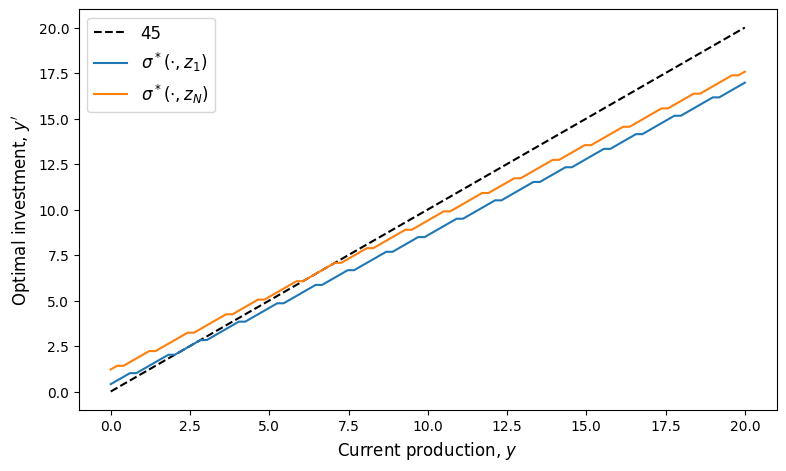

In [37]:
beta, a_0, a_1, gamma, c, y_size, z_size, y_grid, z_grid, Q = model          # Unpacked model parameters

sigma_star = optimistic_policy_iteration(model)                              # Get optimal policy with OPI

fig, ax = plt.subplots(figsize=(9, 5.2))                                     # Create figure and axis, specifiying figsize=(9, 5.2)

ax.plot(y_grid, y_grid, "k--", label="45")                                   # Indentity function
ax.plot(y_grid, y_grid[sigma_star[:, 1]], label="$\\sigma^*(\cdot, z_1)$")   # Given the shock with index 1, graph all the possible policies
ax.plot(y_grid, y_grid[sigma_star[:, -1]], label="$\\sigma^*(\cdot, z_N)$")  # Given the shock in the last index, graph all the possible policies

ax.legend(fontsize = 12)                                  # Set legends and labels
ax.set_xlabel("Current production, $y$", fontsize = 12)
ax.set_ylabel("Optimal investment, $y'$", fontsize = 12)

plt.show()

If $γ=0$, then there's no adjustment costs.

Therefore the **profit maximizing** level of output in every period is...

$$\overline{Y_t}=\frac{a_0-c+Z_t}{2a_1}$$

If in the contrary $γ>0$, then the firm should **implement smoothing**, to take into account adjustment costs.

In the following graphs we show **how the smoothing is implemeted** by the firm for differetn level of $γ>0$, whith the results obtained by the OPI method.

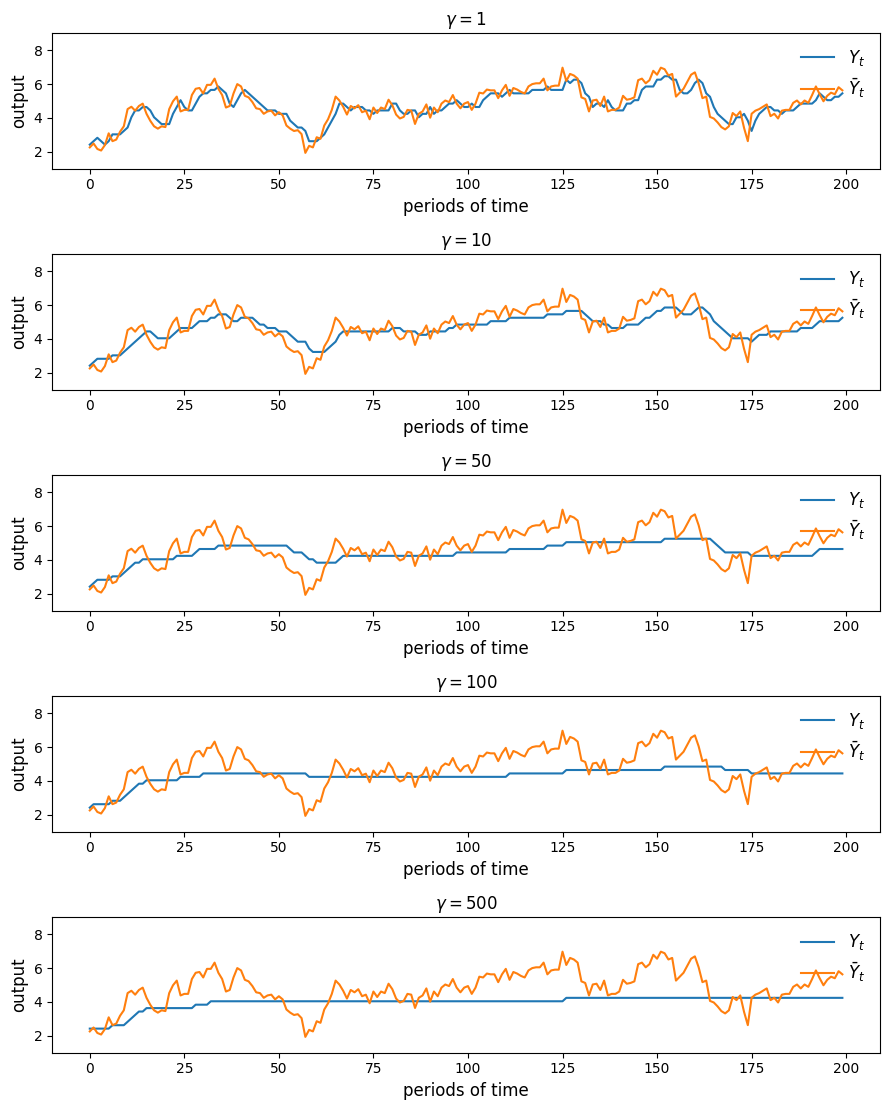

In [38]:
ts_length = 200                                                           # Number of periods in the time series

fig, axes = plt.subplots(5, 1, figsize=(9, 11.2))                         # Create figure and axis

for (ax, gamma) in zip(axes, (1, 10, 50, 100, 500)):                      # Creates a loop that repeat for each subplot and for each gamma value in (1, 10, 50, 100, 500)
    model = create_investment_model(gamma=gamma)                          # For each different gamma value, updates the model parameters
    beta, a_0, a_1, gamma, c, y_size, z_size, y_grid, z_grid, Q = model   # Unpacked model parameters
    sigma_star = optimistic_policy_iteration(model)                       # Gets optimal policy for given model parameters

    np.random.seed(200)  # Set the seed before generating the simulation of z (ensure the same simulation)

    mc = qe.MarkovChain(Q, z_grid)  # Creates a Markov chain using the transition matrix Q and the z_grid.

    z_sim_idx = mc.simulate_indices(ts_length)   # Simulate time series of state transitions, where state indices are returned.
    z_sim = z_grid[z_sim_idx]                    # Evaluate the indices in the grid

    y_sim_idx = np.empty(ts_length, dtype=int)                  # Create an empty array to store production status indexes
    y_1 = (a_0 - c + z_sim[0]) / (2 * a_1)                      # Calculate the first production value y_1 at time t=0.
    y_sim_idx[0] = np.searchsorted(y_grid, y_1)                 # Finds the index in the y_grid that is closest to the value y_1 and assigns it to y_sim_idx[0]
    for t in range(ts_length-1):                                # For each period in (1,200)...
        y_sim_idx[t+1] = sigma_star[y_sim_idx[t], z_sim_idx[t]] #    - Find the index of a simulated production with sigma_star[...]
    y_sim = y_grid[y_sim_idx]                                   #    - Set the production level according to y_sim_idx
    y_bar_sim = (a_0 - c + z_sim) / (2 * a_1)                   #    - Set the production according to demand shocks

    ax.plot(range(ts_length), y_sim, label="$Y_t$")             # Create the graph
    ax.plot(range(ts_length), y_bar_sim, label="$\\bar Y_t$")
    ax.legend(fontsize=12, frameon=False, loc="upper right")
    ax.set_ylabel("output", fontsize=12)
    ax.set_xlabel("periods of time", fontsize=12)
    ax.set_ylim(1, 9)
    ax.set_title(f"$\gamma = {gamma}$", fontsize=12)

fig.tight_layout()
plt.show()